In [1]:
from Function.Function import *
from os.path import abspath , join
from sklearn.preprocessing import normalize ,LabelEncoder,StandardScaler , Normalizer
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from random import shuffle
import matplotlib.pyplot  as plt
current_folder =abspath('');current_folder



'/Users/yangtao/Documents/GitHub/850-project'

# Preprocessing data

In [2]:
methods = ['dropna' ,'fillna_0_after_normalization', 'fillna_0' ,'fillna_mean' ]
method = methods[0]
methods_n_s = ['normalization','standardlization']
methods_n_s = methods_n_s[1]

In [3]:
P_calibrate = 0.8 #  datas for calibrate
# data = pd.read_csv('Data/finalproject_training.csv')
data = pd.read_csv('Data/finalproject_training_xy.csv')

# the xs that was cleaned for useless price data and non number data and NONE data(first check)
data = data.loc[:,data.columns[12:]]
data = data.loc[:,(np.array(data.dtypes == 'int64') ) | (np.array(data.dtypes == 'float64') )]
# process nan (fill na with 0, fill na with mean, ignore nan)

data,frac = process_nan(data , method); print(method)

# separate X and Y
X_data = data.iloc[:,:-1]
Y_data = data.iloc[:,-1]

#normalization or standardlization
def norml_standard(X_data , m = 'standardlization'):
    '''
    normalization or standardlization
    output: processed dataframe
    '''
    #normalization or standardlization
    if m == 'normalization':
        X_data = pd.DataFrame(normalize(X_data, axis=0) , columns = X_data.columns , index = X_data.index)
    elif m == 'standardlization':
        X_data = pd.DataFrame(StandardScaler().fit_transform(X_data) , columns = X_data.columns , index = X_data.index)
    return X_data
if method == methods[1]:
    methods_n_s  = methods_n_s[0]
    print(methods_n_s)
else:
    print(methods_n_s)
    X_data = norml_standard(X_data , methods_n_s)
# calibrate and validation
# sperate the data into calibration and validation. Also,batch shuffle the data to make more samples
X_data ,Y_data = get_data(X_data,Y_data,P_calibrate,batch = 10,frac = frac,shuffle = True)
print(X_data['calibrate']['processed_batch4'].shape)

(2776, 72)
dropna
standardlization
(2220, 71)


# Autoencoder or PCA ?

# lets do Autoencoder with nerual network first

# Construct model

In [4]:
dimension_of_input  = len(X_data['calibrate']['processed'].T) # number of stock
autoencoder = inital_model(dimension_of_input) # inital_model 具体initial的model在function文件里
# train model
# we use net difference to train model
Autoencoder_data = np.array(X_data['calibrate']['processed']) 
# we use pre-trained model with best fit to save time
# if there is no pre_trained model, train one
try:
    path = join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s))
    autoencoder = load_model(path)
except:
    print('train model')
    autoencoder.fit(Autoencoder_data, Autoencoder_data, shuffle=False, epochs=100, batch_size = 10 , verbose = 1)
    autoencoder.save(join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s)))

# Predict and see what the factors is most relevent and explain most variance
# dimension reduction


In [5]:
path = join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s))
autoencoder = load_model(path)
predict = autoencoder.predict(Autoencoder_data) 
# use different error measure to decide which factors explain most variance

# we need to figure out what is the best error measure,?

# sum absolute relative error
communal_information = np.sum(np.absolute((Autoencoder_data - predict)),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : X_data['calibrate']['processed'].columns[ranking] })
ranks

,communal,index
0,165.862121,tfvceq
1,186.247964,txdbclq
2,345.718317,esopctq
3,373.722433,rdipq
4,460.930622,tfvaq
...,...,...
66,1934.835376,fyearq
67,1987.672620,gsubind
68,1987.672771,gind
69,1987.676107,ggroup


### lower the communal_information,higer explaination

### you can do prediction by using autoencoder directly. i can write it down if we decide to do it

# Lets do PCA and backtest
### from here you either use pca classifier or linear regression for prediction


In [6]:
def mse_compare(X_df , Y_df, X_validation_df , Y_validation_df , ranking):
    # number of factors that is used to do regression
    n_factors = [*range(10,len(X_df.columns)//2 + 1, 1)] [::-1]
    # store mse of different method with different number of factors
    mse_pca_calibration = [] # mean squared errors of pca with calibration data
    mse_pca_validation = [] # mean squared errors of pca with validation data
    mse_lg_calibration = [] # mean squared errors of linear regression with calibration data
    mse_lg_validation = [] # mean squared errors of linear regression with validation data
    for k in n_factors:
        # index of factors 
        # the top k factors combined with bottom k factors
        index = list(X_df.columns[ranking[:k]]) + \
                     list(X_df.columns[ranking[-k//5:]])
        # get X data
        data = X_df.loc[:,index]


        # using pca in LinearRegression
        X = np.array(data)
        y = np.array(Y_df)
        pca = PCA(n_components=k//3) #initial model
        X_pca = pca.fit_transform(X) # pca decomposition

        model_pca = LinearRegression()# initial predicition model
        model_pca.fit(X_pca,y) # fit model

        # record mse
        mse_pca_calibration.append(mean_squared_error(model_pca.predict(X_pca),y))
        # out of sample-validation
        # get validation X data and Y data
        X_test =  np.array(X_validation_df.loc[:,index]) 
        X_test_pca = pca.fit_transform(X_test)
        y_test = np.array(Y_validation_df)

        # record mse(validation)
        mse_pca_validation.append(mean_squared_error(model_pca.predict(X_test_pca),y_test))

        ## compare with the performance of linear regression without PCA

        model = LinearRegression()# initial predicition model
        model.fit(X,y) # fit model
        # record mse
        mse_lg_calibration.append(mean_squared_error(model.predict(X),y))
        mse_lg_validation.append(mean_squared_error(model.predict(X_test),y_test))
        # present mse
    mse = {'mse_pca_calibration' : mse_pca_calibration, 'mse_pca_validation' : mse_pca_validation, \
                       'mse_lg_calibration' : mse_lg_calibration, 'mse_lg_validation' : mse_lg_validation}
    mse_df = pd.DataFrame(mse , index = np.array(n_factors)  +  np.array(n_factors)//5)
    return mse_df

In [7]:
mse_df = mse_compare(X_data['calibrate']['processed'] ,Y_data['calibrate']['processed'],\
                      X_data['validation']['processed'] ,Y_data['validation']['processed'] , ranking)
mse_df

,mse_pca_calibration,mse_pca_validation,mse_lg_calibration,mse_lg_validation
42,0.009963,0.010769,0.009687,0.010135
40,0.009963,0.010758,0.009687,0.010136
39,0.009963,0.010743,0.009688,0.010127
38,0.009976,0.010719,0.009689,0.010128
37,0.009971,0.010571,0.009689,0.010127
36,0.010024,0.010572,0.009718,0.010169
34,0.010035,0.010578,0.009721,0.010140
33,0.010035,0.010639,0.009721,0.010141
32,0.010034,0.010663,0.009721,0.010148
31,0.010040,0.010609,0.009723,0.010194


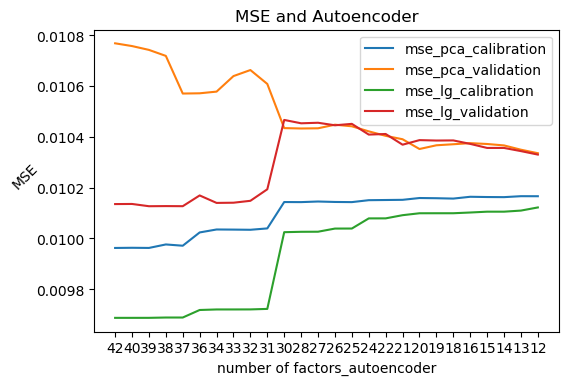

In [8]:
# plot mse
plt.figure(dpi = 100)
plt.plot(mse_df.reset_index().iloc[:,1:] )
plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
plt.legend(mse_df.columns)
plt.xlabel('number of factors_autoencoder')
plt.ylabel('MSE',rotation = 45)
plt.title('MSE and Autoencoder')
plt.show()

In [9]:
mse_batch = []
batch_keys = [*X_data['calibrate'].keys()][1:]
for i in range(len(batch_keys) ):
    mse_df = mse_compare(X_data['calibrate'][batch_keys[i]] ,Y_data['calibrate'][batch_keys[i]],\
                      X_data['validation'][batch_keys[i]] ,Y_data['validation'][batch_keys[i]],ranking )
    mse_batch.append(mse_df)

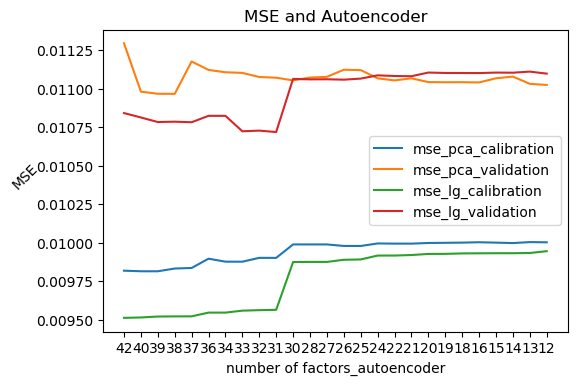

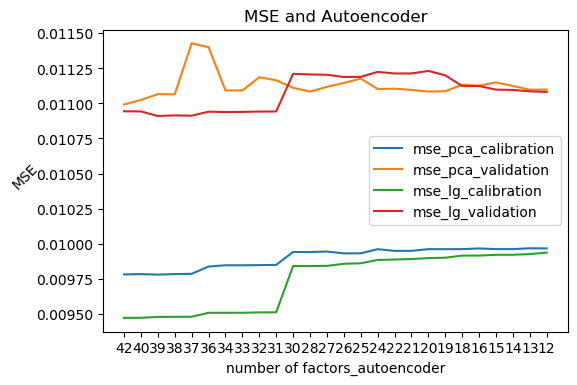

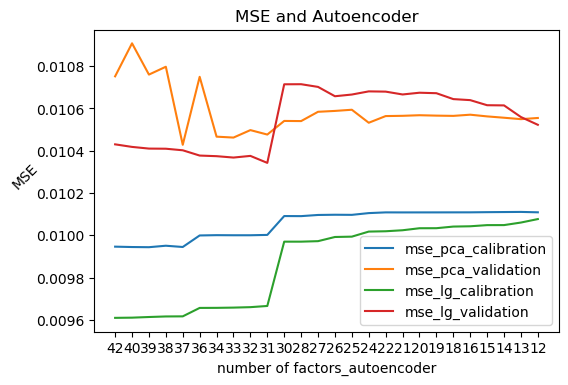

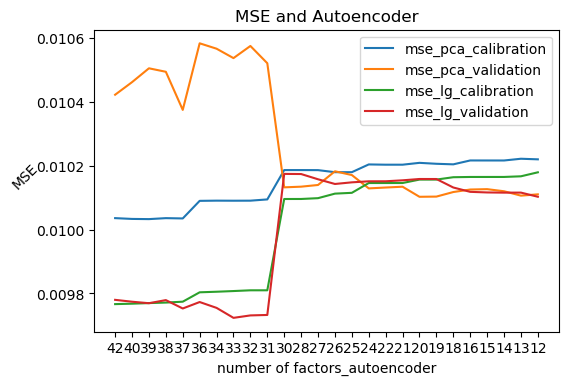

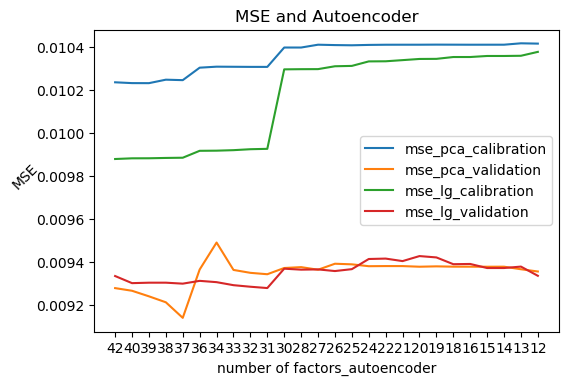

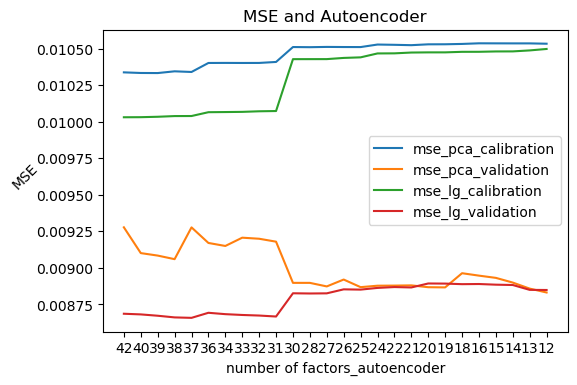

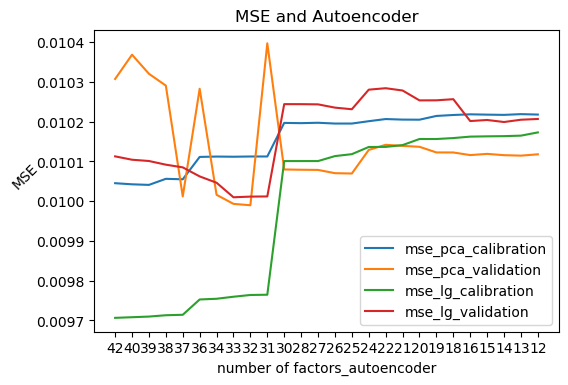

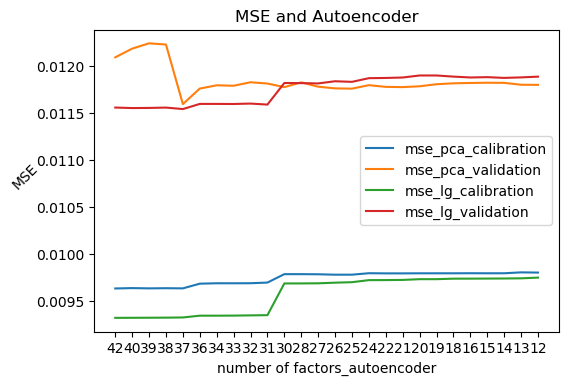

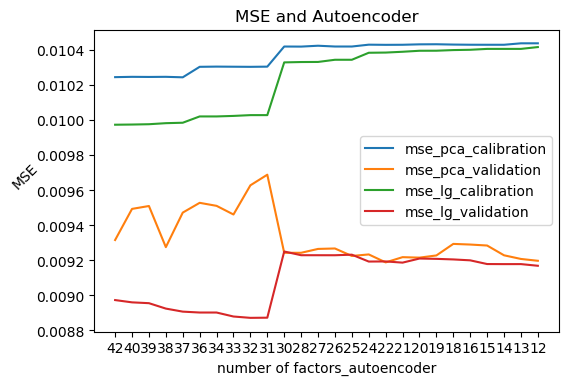

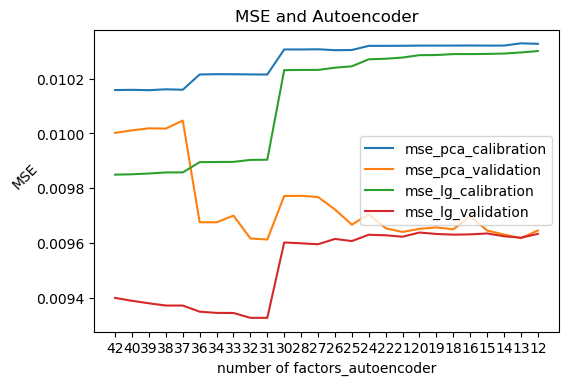

In [10]:
for i in mse_batch:
    plt.figure(dpi = 100)
    plt.plot(i.reset_index().iloc[:,1:] )
    plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
    plt.legend(i.columns)
    plt.xlabel('number of factors_autoencoder')
    plt.ylabel('MSE',rotation = 45)
    plt.title('MSE and Autoencoder')
    plt.show()

In [11]:
accurcy_pca_calibrate = []
accurcy_pca_validation = []
accurcy_lg_calibrate = []
accurcy_lg_validation = []
n_factors = [*range(10,len(X_data['calibrate']['processed'].columns)//2 + 1, 2)] [::-1]
for k in n_factors:
    index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
             list(X_data['calibrate']['processed'].columns[ranking[-k:]])
    data = X_data['calibrate']['processed'].loc[:,index]
    rf = LogisticRegression()
    X = data
    y = Y_data['calibrate']['direction']
    pca = PCA(n_components=2) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition

    rf.fit(X_pca,y)

    accurcy_pca_calibrate.append(rf.score(X_pca,y))

    X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 
    X_test_pca = pca.fit_transform(X_test)
    y_test = Y_data['validation']['direction']

    accurcy_pca_validation.append(rf.score(X_test_pca,y_test))
    
    model = LinearRegression()# initial predicition model
    model.fit(X,y)

    accurcy_lg_calibrate.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X)]) == y )/ len(y))

    accurcy_lg_validation.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X_test)])  == y_test )/ len(y_test))
accurcy= {'accurcy_pca_validation' : accurcy_pca_validation, 'accurcy_pca_calibrate' : accurcy_pca_calibrate, \
                   'accurcy_lg_calibrate' : accurcy_lg_calibrate, 'accurcy_lg_validation' : accurcy_lg_validation}
accurcy_dt = pd.DataFrame(accurcy , index = n_factors)    ;

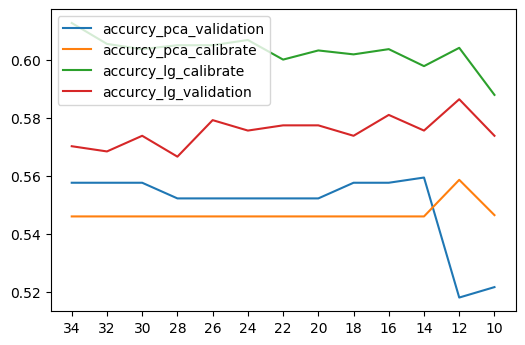

In [12]:
plt.figure(dpi =100)
plt.plot(accurcy_dt.reset_index().iloc[:,1:] )
plt.legend(accurcy_dt.columns)
plt.xticks(range(len(accurcy_dt.index)) , accurcy_dt.index)
plt.show()

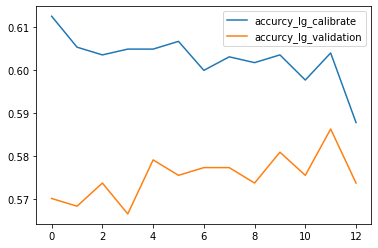

In [13]:
accurcy_dt.loc[:,['accurcy_lg_calibrate' , 'accurcy_lg_validation']].plot(use_index=False)

In [14]:
# k = 10
# n_components = range(1,k*2 -1,1)


# index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
#          list(X_data['calibrate']['processed'].columns[ranking[-k:]])
# data = X_data['calibrate']['processed'].loc[:,index]

# X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 

# y_test = Y_data['validation']['direction']
# accurcy_pca_calibrate = []
# accurcy_pca_validation = []

# for s in n_components:
#     rf = RandomForestClassifier()
#     X = data
#     y = Y_data['calibrate']['direction']
#     pca = PCA(n_components=s) #initial model
#     X_pca = pca.fit_transform(X) # pca decomposition
#     X_test_pca = pca.fit_transform(X_test)
#     rf.fit(X_pca,y)

#     accurcy_pca_calibrate.append(rf.score(X_pca,y))
#     accurcy_pca_validation.append(rf.score(X_test_pca,y_test))


# plt.plot(accurcy_pca_validation)



# print(max(accurcy_pca_validation))
# print(accurcy_pca_validation.index(max(accurcy_pca_validation)))